In [19]:

!pip install -q folium geopandas shapely tqdm

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import folium
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

def find_csv_file(prefix=None):
    search_paths = ['/mnt/data', '.', '/content']
    candidates = []
    for p in search_paths:
        if os.path.exists(p):
            candidates += glob.glob(os.path.join(p, '*.csv'))
    if prefix:
        candidates = [c for c in candidates if prefix.lower() in os.path.basename(c).lower()]
    return candidates

csvs = find_csv_file()
print("CSV files found:", csvs)
if not csvs:
    raise FileNotFoundError("No CSV files found in /mnt/data or current directory. Upload your CSV and re-run.")
csv_path = csvs[0]
print("Using CSV:", csv_path)

CSV files found: ['./climate_nasa (1).csv', './test_predictions_summary.csv', '/content/climate_nasa (1).csv', '/content/test_predictions_summary.csv']
Using CSV: ./climate_nasa (1).csv


In [20]:
df = pd.read_csv(csv_path)
print("Data shape:", df.shape)
display(df.head())

Data shape: (522, 5)


,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [21]:
df.columns = [c.strip() for c in df.columns]
print("Columns:", len(df.columns))
print(df.info())

for c in ['Date', 'date', 'date_time']:
    if c in df.columns:
        try:
            df['date'] = pd.to_datetime(df[c], errors='coerce')
            break
        except Exception:
            pass

if 'year' in df.columns:
    print("Years in data:", sorted(df['year'].unique()))
if 'week_no' in df.columns:
    print("Week number sample:", df['week_no'].unique()[:5])

Columns: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None


In [22]:
target_candidates = ['emission','Emission','CO2','co2']
target_col = None
for t in target_candidates:
    if t in df.columns:
        target_col = t
        break
if not target_col:
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    print("Numeric columns found:", numeric_cols[:20])
    if numeric_cols:
        target_col = numeric_cols[0]
        print("No explicit 'emission' column; falling back to:", target_col)
    else:
        raise ValueError("No numeric columns detected to use as target. Please provide the target column name.")

print("Target column set to:", target_col)


Numeric columns found: ['likesCount', 'commentsCount']
No explicit 'emission' column; falling back to: likesCount
Target column set to: likesCount


Basic stats for target:


,likesCount
count,522.000000
mean,4.720307
std,12.053556
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,126.000000


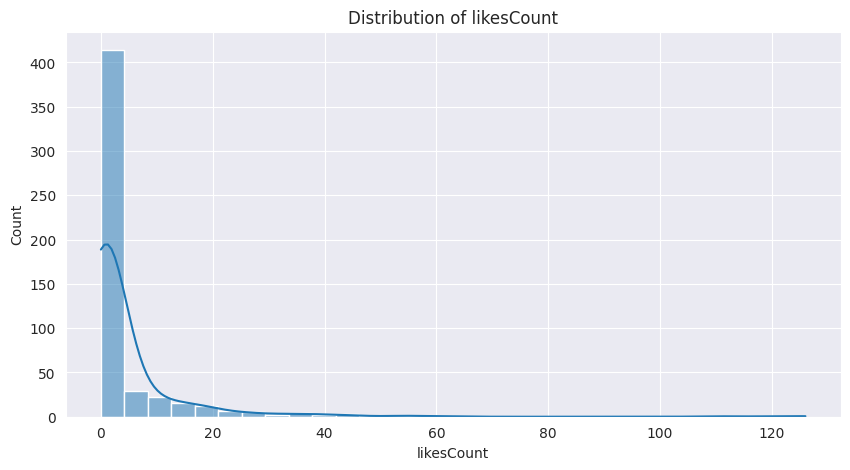

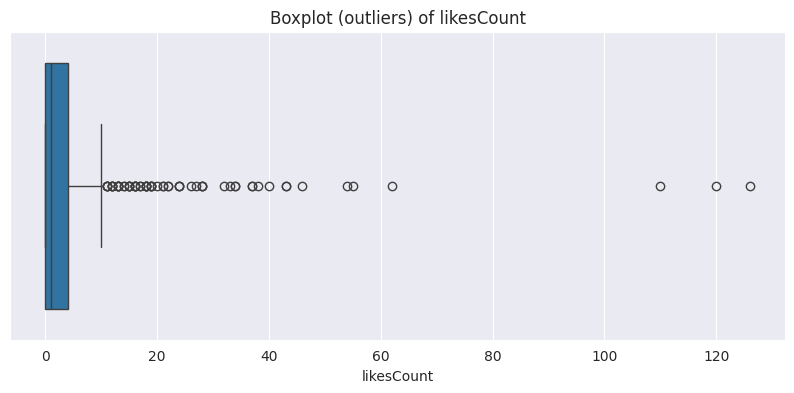

Skewness of likesCount: 6.009
Applying log1p transform to target to reduce skew.


In [23]:

print("Basic stats for target:")
display(df[target_col].describe())
plt.figure(figsize=(10,5))
sns.histplot(df[target_col].dropna(), bins=30, kde=True)
plt.title(f"Distribution of {target_col}")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x=df[target_col].dropna())
plt.title(f"Boxplot (outliers) of {target_col}")
plt.show()

skewness = df[target_col].dropna().skew()
print(f"Skewness of {target_col}: {skewness:.3f}")
if skewness > 1.0:
    print("Applying log1p transform to target to reduce skew.")
    df[target_col + '_log1p'] = np.log1p(df[target_col])
    model_target = target_col + '_log1p'
else:
    model_target = target_col

,0
commentsCount,278
text,18


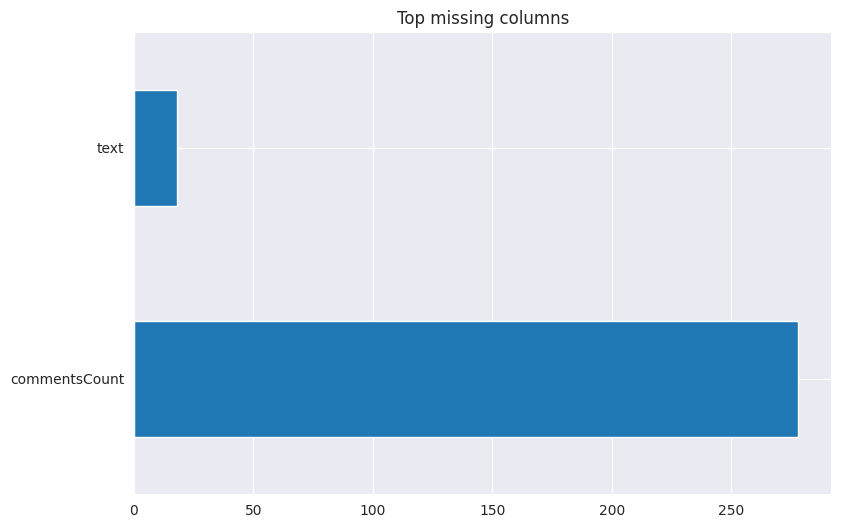

Numeric cols: 3 Categorical cols: 2


In [24]:

missing = df.isna().sum().sort_values(ascending=False)
if missing[missing > 0].sum() > 0: # Add this check
    display(missing[missing>0].head(20))
    plt.figure(figsize=(9,6))
    missing[missing>0].head(20).plot(kind='barh')
    plt.title("Top missing columns")
    plt.show()
else:
    print("No missing values found.")


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

for c in cat_cols:
    df[c] = df[c].fillna('missing')

In [25]:

if 'latitude' in df.columns and 'longitude' in df.columns:
    df['lat_r'] = df['latitude'].round(2)
    df['lon_r'] = df['longitude'].round(2)
    df['location'] = df['lat_r'].astype(str) + '_' + df['lon_r'].astype(str)
    print("Created location column from latitude/longitude.")

if 'year' in df.columns and 'week_no' in df.columns and 'date' not in df.columns:
    def week_to_date(y, w):
        try:
            return pd.to_datetime(f'{int(y)}-W{int(w)}-1', format='%Y-W%W-%w', errors='coerce')
        except:
            return pd.NaT
    df['date_est'] = df.apply(lambda r: week_to_date(r['year'], r['week_no']), axis=1)
    df['date'] = df['date'].fillna(df['date_est'])
    print("Created date_est from year & week_no.")

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek

,likesCount_log1p
likesCount_log1p,1.000000
likesCount,0.761440
commentsCount,0.398780
month,0.135647
day,0.053811
dayofweek,0.012327


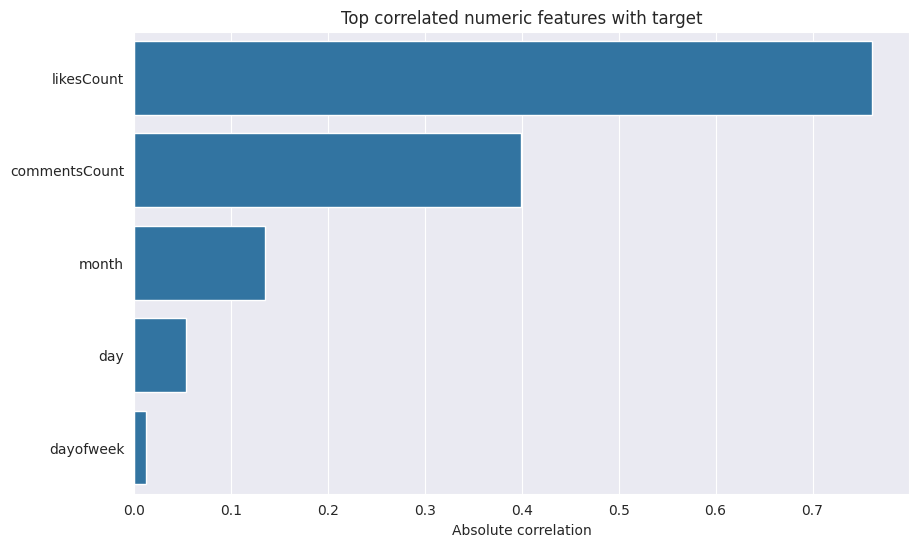

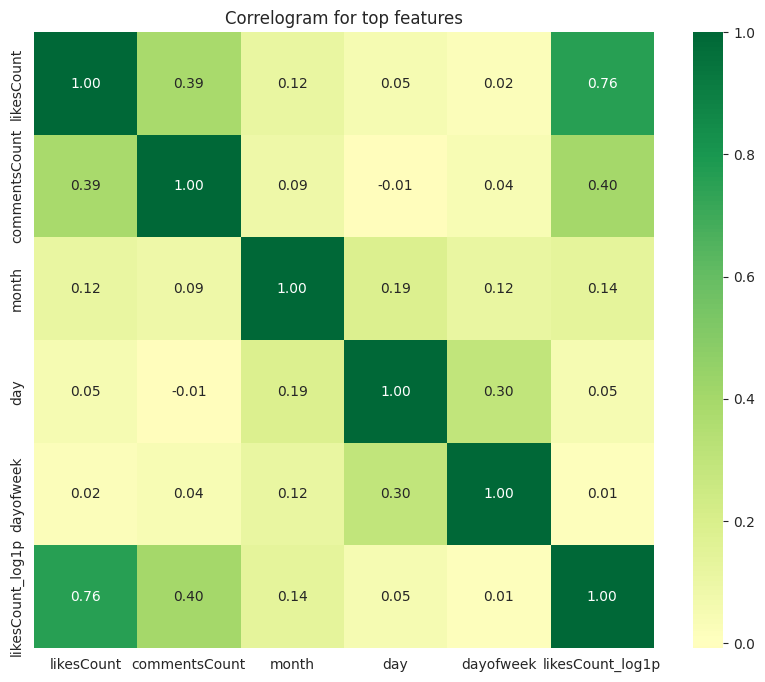

In [26]:
numeric_df = df.select_dtypes(include=[np.number])
corrs = numeric_df.corr()[model_target].abs().sort_values(ascending=False)
display(corrs.head(20))

top_feats = corrs.index[1:11].tolist()
plt.figure(figsize=(10,6))
sns.barplot(x=corrs[top_feats].values, y=top_feats)
plt.title("Top correlated numeric features with target")
plt.xlabel("Absolute correlation")
plt.show()

plt.figure(figsize=(10,8))

heatmap_data = df[top_feats + [model_target]].select_dtypes(include=[np.number])
sns.heatmap(heatmap_data.corr(), annot=True, fmt=".2f", cmap='RdYlGn', center=0)
plt.title("Correlogram for top features")
plt.show()


In [27]:
if 'location' in df.columns and 'week_no' in df.columns:
    sample_loc = df.groupby(['location','year']).size().reset_index().head(1)
    sample_location = df['location'].mode()[0]
    print("Sample location used for time-series:", sample_location)
    loc_df = df[df['location'] == sample_location].sort_values(['year','week_no'])
    if not loc_df.empty:
        plt.figure(figsize=(12,5))
        sns.lineplot(data=loc_df, x='week_no', y=target_col, hue='year', marker='o')
        plt.title(f"{target_col} across weeks for location {sample_location}")
        plt.show()

In [28]:
if 'latitude' in df.columns and 'longitude' in df.columns:

    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    sample_points = df.sample(n=min(1000, len(df)), random_state=42)
    for _, row in sample_points.iterrows():
        folium.CircleMarker(location=[row['latitude'], row['longitude']],
                            radius=2,
                            popup=f"{target_col}: {row[target_col]:.3f}",
                            fill=True).add_to(m)

    map_path = "/content/climate_points_map.html"
    m.save(map_path)
    print("Saved folium map to:", map_path)

In [29]:
exclude = ['ID','id','Id','index']
exclude += [target_col, model_target] if model_target is not None else []
features = [c for c in num_cols if c not in exclude]

for f in ['month','day','dayofweek']:
    if f in df.columns and f not in features:
        features.append(f)


print("Training features (sample):", features[:15])
X = df[features].copy()
y = df[model_target].copy() if model_target in df.columns else df[target_col].copy()

# simple train-test split, dropping NaNs if any
mask = ~X.isna().any(axis=1) & ~y.isna()
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test shapes:", X_train.shape, X_test.shape)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


Training features (sample): ['commentsCount', 'month', 'day', 'dayofweek']
Train/Test shapes: (417, 4) (105, 4)


In [30]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

MAE: 0.8211, RMSE: 1.0643, R2: 0.0099


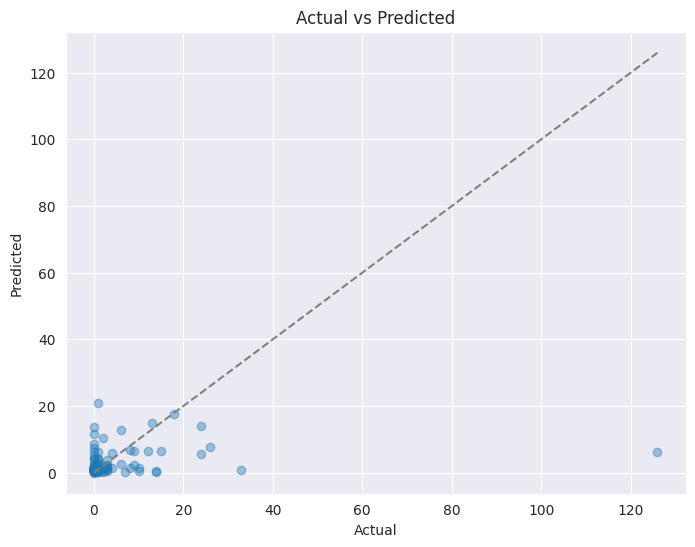

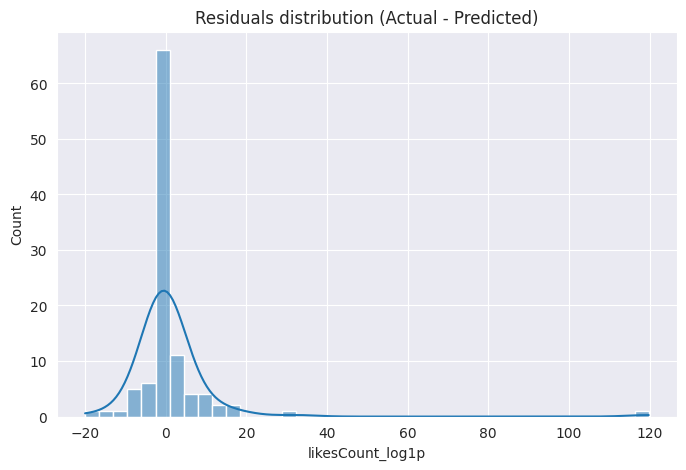

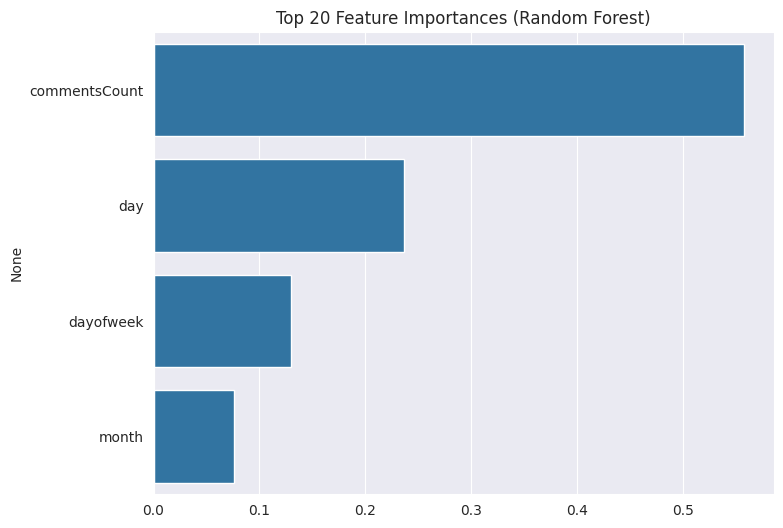

In [31]:
y_pred = rf.predict(X_test_s)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

def inv_transform(arr):
    if model_target.endswith('_log1p'):
        return np.expm1(arr)  # inverse log1p
    return arr

# Scatter actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(inv_transform(y_test), inv_transform(y_pred), alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
lims = [min(inv_transform(np.concatenate([y_test,y_pred]))), max(inv_transform(np.concatenate([y_test,y_pred])))]
plt.plot(lims, lims, '--', color='gray')
plt.show()

# Residual plot
residuals = inv_transform(y_test) - inv_transform(y_pred)
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residuals distribution (Actual - Predicted)')
plt.show()


fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
sns.barplot(x=fi.values, y=fi.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()


In [32]:
import joblib
joblib.dump(rf, '/content/rf_model.joblib')
joblib.dump(scaler, '/content/scaler.joblib')
print("Saved model and scaler in /content/")

Saved model and scaler in /content/


In [33]:
future_candidates = find_csv_file(prefix='future')
if future_candidates:
    future = pd.read_csv(future_candidates[0])

    future_X = future[features].fillna(0)
    future_X_s = scaler.transform(future_X)
    future_preds = rf.predict(future_X_s)
    future['predicted'] = inv_transform(future_preds)
    display(future.head())
else:
    print("No 'future' CSV detected; skip future predictions.")

No 'future' CSV detected; skip future predictions.


In [34]:
pred_df = X_test.copy()
pred_df['actual'] = inv_transform(y_test)
pred_df['predicted'] = inv_transform(y_pred)
pred_df.to_csv('/content/test_predictions_summary.csv', index=False)
print("Saved test predictions summary to /content/test_predictions_summary.csv")


print("Notebook run complete. Files saved: /content/rf_model.joblib, /content/scaler.joblib, /content/test_predictions_summary.csv")
if 'latitude' in df.columns and 'longitude' in df.columns:
    if os.path.exists(map_path):
        print("Map file:", map_path)

Saved test predictions summary to /content/test_predictions_summary.csv
Notebook run complete. Files saved: /content/rf_model.joblib, /content/scaler.joblib, /content/test_predictions_summary.csv


# New Section